# Food Delivery Time estimation

## 1. Data Preparation

### 1.1 Import libraries

In [226]:
from module.distance_calculator import DistanceCalculator

import numpy as np
import pandas as pd

from math import sqrt, cos

import datetime
from datetime import time, date, datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import metrics


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

### 1.2 Exploratory Data Analysis (EDA)

### 1.2.1 Examine data

In [227]:
# Read in the data
df = pd.read_excel("Capstone SampleData 14days.xlsx", sheet_name="Sheet1", header=0)

In [228]:
# Check the data types
df.head()

,JobAcceptedDate,jobAcceptedTime,calledMerchantTime,arrivedAtMerchantTime,mealPickedUpTime,arrivedAtCustLocationTime,foodDeliveredTime,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,MerchantName,NationFoodCategory,FoodCategories
0,2020-10-03,20:39:15.840000,20:40:51.840000,20:48:19.840000,20:49:18.840000,21:14:09.840000,21:15:12.840000,13.825853,100.551958,13.825703,100.559309,13.756065,100.562375,3K SEA ZABB,Thai,อาหารทะเล
1,2020-10-01,12:54:34.560000,12:55:38.560000,13:10:26.560000,13:24:56.560000,14:01:00.560000,14:01:39.560000,13.819283,100.561874,13.831056,100.570731,13.774685,100.573913,ร้านอาหารอีสานแม่อลิส,Thai,อาหารอีสาน
2,2020-10-01,12:32:06.720000,12:32:21.720000,12:41:08.720000,12:46:41.720000,13:22:01.720000,13:22:53.720000,13.827041,100.554284,13.827205,100.536048,13.743898,100.571659,ไก่ย่างห้าดาว กรุงเทพ-นนท์44,Thai,Fast Food
3,2020-10-03,13:19:03.360000,13:20:04.360000,13:32:37.360000,13:45:46.360000,14:14:28.360000,14:15:47.360000,13.820453,100.557910,13.840180,100.542326,13.803957,100.513704,กิวกิวเต้ ประชาชื่น,Japanese,ปิ้งย่าง
4,2020-10-13,11:08:26.880000,11:09:03.880000,11:13:43.880000,11:15:32.880000,11:40:26.880000,11:41:23.880000,13.825773,100.567170,13.827034,100.564534,13.775817,100.575734,ร้านอาหาร วินเทส,Thai,อาหารตามสั่ง


In [229]:
# Check the data informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   JobAcceptedDate            10000 non-null  datetime64[ns]
 1   jobAcceptedTime            10000 non-null  object        
 2   calledMerchantTime         10000 non-null  object        
 3   arrivedAtMerchantTime      10000 non-null  object        
 4   mealPickedUpTime           10000 non-null  object        
 5   arrivedAtCustLocationTime  10000 non-null  object        
 6   foodDeliveredTime          10000 non-null  object        
 7   riderInitial.lat           10000 non-null  float64       
 8   riderInitial.long          10000 non-null  float64       
 9   Merchant.Lat               10000 non-null  float64       
 10  Merchant.Lng               10000 non-null  float64       
 11  Customer.lat               10000 non-null  float64       
 12  Custo

In [230]:
# Check the data shape
df.shape

(10000, 16)

### 1.2.2 Remove unused columns

In [231]:
# Remove the columns that are not needed
drop_list = ["calledMerchantTime",
             "arrivedAtMerchantTime",
             "foodDeliveredTime",
             "riderInitial.lat",
             "riderInitial.long",
             "MerchantName",
             "NationFoodCategory",
             "FoodCategories"]
try:
    df.drop(drop_list, axis=1, inplace=True)
except KeyError:
    print("Columns already removed")

display(df.head(3))

,JobAcceptedDate,jobAcceptedTime,mealPickedUpTime,arrivedAtCustLocationTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng
0,2020-10-03,20:39:15.840000,20:49:18.840000,21:14:09.840000,13.825703,100.559309,13.756065,100.562375
1,2020-10-01,12:54:34.560000,13:24:56.560000,14:01:00.560000,13.831056,100.570731,13.774685,100.573913
2,2020-10-01,12:32:06.720000,12:46:41.720000,13:22:01.720000,13.827205,100.536048,13.743898,100.571659


### 1.2.3 Change data types (time, date -> datetime)
datetime data type can find interval but both time and date data types cannot.

In [232]:
def to_datetime(df, date_col, time_col):
    return pd.to_datetime(df[date_col].astype(str) + " " + df[time_col].astype(str))

In [233]:
if not isinstance(df["mealPickedUpTime"].iloc[0], datetime):
    df["mealPickedUpTime"]    = to_datetime(df, "JobAcceptedDate", "mealPickedUpTime")
if not isinstance(df["arrivedAtCustLocationTime"].iloc[0], datetime):
    df["arrivedAtCustLocationTime"] = to_datetime(df, "JobAcceptedDate", "arrivedAtCustLocationTime")

### 1.2.3 Create target from existed columns

In [234]:
df["DeliveryTime"] = df["arrivedAtCustLocationTime"] - df["mealPickedUpTime"]
df["DeliveryTime (s)"] = df["DeliveryTime"].apply(lambda x: x.total_seconds())
df["DeliveryTime (m)"] = df["DeliveryTime"].apply(lambda x: round(x.total_seconds()/60))

In [235]:
# Remove the columns that are not needed
drop_list = ["arrivedAtCustLocationTime",
             "mealPickedUpTime",
             "DeliveryTime"]
try:
    df.drop(drop_list, axis=1, inplace=True)
except KeyError:
    print("Columns already removed")

display(df.head(3))

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m)
0,2020-10-03,20:39:15.840000,13.825703,100.559309,13.756065,100.562375,1491.0,25
1,2020-10-01,12:54:34.560000,13.831056,100.570731,13.774685,100.573913,2164.0,36
2,2020-10-01,12:32:06.720000,13.827205,100.536048,13.743898,100.571659,2120.0,35


In [236]:
df.describe()

,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m)
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,13.828060,100.559658,13.795584,100.564746,1821.204700,30.355000
std,0.005297,0.010585,0.044893,0.030013,755.673662,12.599034
min,13.811964,100.526637,13.738166,100.484028,181.000000,3.000000
25%,13.824620,100.555560,13.754118,100.544932,1245.000000,21.000000
50%,13.827034,100.563396,13.788780,100.564803,1814.000000,30.000000
75%,13.828517,100.564534,13.825360,100.580921,2375.000000,40.000000
max,13.843905,100.580416,13.914579,100.661622,4271.000000,71.000000


<AxesSubplot: >

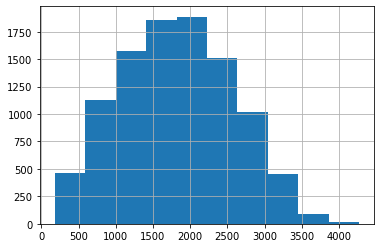

In [237]:
df["DeliveryTime (s)"].hist()

<AxesSubplot: >

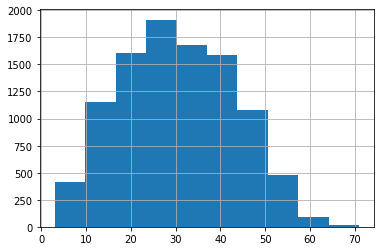

In [238]:
df["DeliveryTime (m)"].hist()

### 1.2.4 Add additional features

In [239]:
def get_euc(coords_1, coords_2):
    R = 6371000; conversion_const = 0.0174533
    c_1 = (coords_1[0]*conversion_const, coords_1[1]*conversion_const)
    c_2 = (coords_2[0]*conversion_const, coords_2[1]*conversion_const)
    delta_phi = abs(c_1[1]-c_2[1])
    theta = c_1[0]
    delta_theta = abs(c_1[0]-c_2[0])
    del_x = R*cos(theta)*delta_phi 
    del_y = R*delta_theta
    return sqrt(del_x**2 + del_y**2)

In [240]:
df["EucDist"] = df.apply(lambda x: get_euc((x["Merchant.Lat"],x["Merchant.Lng"]),(x["Customer.lat"],x["Customer.lng"])), axis=1)

In [241]:
# plt.scatter(df["EucDist"], df["DeliveryTime (m)"])

In [242]:
# plt.scatter(df["EucDist"], df["DeliveryTime (s)"])

In [243]:
df["isHoliday"] = df["JobAcceptedDate"].apply(lambda x: int(x == pd.Timestamp('2020-10-13 00:00:00')))
mapper = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"} # TODO
df["day_of_week"] = df["JobAcceptedDate"].apply(lambda x: x.weekday())
df["day_of_week_name"] = df["JobAcceptedDate"].apply(lambda x: mapper[x.weekday()])

In [244]:
df.head()

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist,isHoliday,day_of_week,day_of_week_name
0,2020-10-03,20:39:15.840000,13.825703,100.559309,13.756065,100.562375,1491.0,25,7750.511440,0,5,Sat
1,2020-10-01,12:54:34.560000,13.831056,100.570731,13.774685,100.573913,2164.0,36,6277.603705,0,3,Thu
2,2020-10-01,12:32:06.720000,13.827205,100.536048,13.743898,100.571659,2120.0,35,10029.576224,0,3,Thu
3,2020-10-03,13:19:03.360000,13.840180,100.542326,13.803957,100.513704,1722.0,29,5076.637568,0,5,Sat
4,2020-10-13,11:08:26.880000,13.827034,100.564534,13.775817,100.575734,1494.0,25,5822.057209,1,1,Tue


In [245]:
# One Hot encode
nominal_columns = ["day_of_week_name"]
dummy_df = pd.get_dummies(df[nominal_columns], drop_first=False)
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(nominal_columns, axis=1)

In [246]:
df

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist,isHoliday,day_of_week,day_of_week_name_Fri,day_of_week_name_Mon,day_of_week_name_Sat,day_of_week_name_Sun,day_of_week_name_Thu,day_of_week_name_Tue,day_of_week_name_Wed
0,2020-10-03,20:39:15.840000,13.825703,100.559309,13.756065,100.562375,1491.0,25,7750.511440,0,5,0,0,1,0,0,0,0
1,2020-10-01,12:54:34.560000,13.831056,100.570731,13.774685,100.573913,2164.0,36,6277.603705,0,3,0,0,0,0,1,0,0
2,2020-10-01,12:32:06.720000,13.827205,100.536048,13.743898,100.571659,2120.0,35,10029.576224,0,3,0,0,0,0,1,0,0
3,2020-10-03,13:19:03.360000,13.840180,100.542326,13.803957,100.513704,1722.0,29,5076.637568,0,5,0,0,1,0,0,0,0
4,2020-10-13,11:08:26.880000,13.827034,100.564534,13.775817,100.575734,1494.0,25,5822.057209,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2020-10-04,20:37:58.080000,13.831056,100.570731,13.740277,100.566035,2692.0,45,10106.915791,0,6,0,0,0,1,0,0,0
9996,2020-10-05,08:13:55.200000,13.827034,100.564534,13.739573,100.555864,2887.0,48,9770.186216,0,0,0,1,0,0,0,0,0
9997,2020-10-04,16:39:47.520000,13.836996,100.540408,13.875017,100.516766,1462.0,24,4938.553701,0,6,0,0,0,1,0,0,0
9998,2020-10-03,12:05:19.680000,13.839923,100.547567,13.770979,100.630330,3633.0,61,11773.601221,0,5,0,0,1,0,0,0,0


In [247]:
## Try to convert one hot to angular distance (https://www.mikulskibartosz.name/time-in-machine-learning/)
df["day_of_week_sin"] = np.sin(df["day_of_week"]*(2.*np.pi/7))
df["day_of_week_cos"] = np.cos(df["day_of_week"]*(2.*np.pi/7))

In [248]:
df

,JobAcceptedDate,jobAcceptedTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist,isHoliday,day_of_week,day_of_week_name_Fri,day_of_week_name_Mon,day_of_week_name_Sat,day_of_week_name_Sun,day_of_week_name_Thu,day_of_week_name_Tue,day_of_week_name_Wed,day_of_week_sin,day_of_week_cos
0,2020-10-03,20:39:15.840000,13.825703,100.559309,13.756065,100.562375,1491.0,25,7750.511440,0,5,0,0,1,0,0,0,0,-0.974928,-0.222521
1,2020-10-01,12:54:34.560000,13.831056,100.570731,13.774685,100.573913,2164.0,36,6277.603705,0,3,0,0,0,0,1,0,0,0.433884,-0.900969
2,2020-10-01,12:32:06.720000,13.827205,100.536048,13.743898,100.571659,2120.0,35,10029.576224,0,3,0,0,0,0,1,0,0,0.433884,-0.900969
3,2020-10-03,13:19:03.360000,13.840180,100.542326,13.803957,100.513704,1722.0,29,5076.637568,0,5,0,0,1,0,0,0,0,-0.974928,-0.222521
4,2020-10-13,11:08:26.880000,13.827034,100.564534,13.775817,100.575734,1494.0,25,5822.057209,1,1,0,0,0,0,0,1,0,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2020-10-04,20:37:58.080000,13.831056,100.570731,13.740277,100.566035,2692.0,45,10106.915791,0,6,0,0,0,1,0,0,0,-0.781831,0.623490
9996,2020-10-05,08:13:55.200000,13.827034,100.564534,13.739573,100.555864,2887.0,48,9770.186216,0,0,0,1,0,0,0,0,0,0.000000,1.000000
9997,2020-10-04,16:39:47.520000,13.836996,100.540408,13.875017,100.516766,1462.0,24,4938.553701,0,6,0,0,0,1,0,0,0,-0.781831,0.623490
9998,2020-10-03,12:05:19.680000,13.839923,100.547567,13.770979,100.630330,3633.0,61,11773.601221,0,5,0,0,1,0,0,0,0,-0.974928,-0.222521


### 1.2.5 Extract input/output for train model

In [249]:
y_s = df.pop("DeliveryTime (s)")
y_m = df.pop("DeliveryTime (m)")
# data without day of week
selected_cols_1 = ["Merchant.Lat", "Merchant.Lng", "Customer.lat", "Customer.lng", "EucDist"]
# data with day of week (onehot)
selected_cols_2 = ["Merchant.Lat", "Merchant.Lng", "Customer.lat", "Customer.lng", "EucDist", "isHoliday",\
    'day_of_week_name_Mon', 'day_of_week_name_Tue', 'day_of_week_name_Wed', 'day_of_week_name_Thu', 'day_of_week_name_Fri', 'day_of_week_name_Sat', 'day_of_week_name_Sun']
# data with day of week (angular distance)
selected_cols_3 = ["Merchant.Lat", "Merchant.Lng", "Customer.lat", "Customer.lng", "EucDist", "isHoliday", "day_of_week_sin",	"day_of_week_cos"]
X = [df[selected_cols_1].copy(), df[selected_cols_2].copy(), df[selected_cols_3].copy()]

## 3. Model Regression

### 3.1 Split data for train and test

In [250]:
Xs_trains = []; Xs_tests = []; ys_trains = []; ys_tests = []
Xm_trains = []; Xm_tests = []; ym_trains = []; ym_tests = []

for i in range(len(X)):
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(X[i], y_s, test_size=0.20, random_state=0)
    Xm_train, Xm_test, ym_train, ym_test = train_test_split(X[i], y_m, test_size=0.20, random_state=0)
    Xs_trains.append(Xs_train); Xs_tests.append(Xs_test); ys_trains.append(ys_train); ys_tests.append(ys_test)
    Xm_trains.append(Xm_train); Xm_tests.append(Xm_test); ym_trains.append(ym_train); ym_tests.append(ym_test)

### 3.2 Model Metrics

In [251]:
met = pd.DataFrame({"Model": [], "MAE": [], "MSE": [], "RMSE": [], "R2": []})
model_metrics_s = [met.copy(), met.copy(), met.copy()]
model_metrics_m = [met.copy(), met.copy(), met.copy()]

### 3.3 Baseline model (Average)

In [252]:
all_predictions_s = [[],[],[]]; all_predictions_m = [[],[],[]]

### 3.3.1 As second

In [253]:
avg_predictions_s = np.full(len(ys_tests[i]), np.mean(ys_trains[i]))
for i in range(len(X)):
    MAE  = metrics.mean_absolute_error(ys_tests[i], avg_predictions_s)
    MSE  = metrics.mean_squared_error(ys_tests[i], avg_predictions_s)
    R2   = metrics.r2_score(ys_tests[i], avg_predictions_s)
    RMSE = np.sqrt(metrics.mean_squared_error(ys_test, avg_predictions_s))

    all_predictions_s[i].append(avg_predictions_s)
    model_metrics_s[i].loc[len(model_metrics_s[i])] = list(["Mean ", MAE, MSE, RMSE, R2])
    

### 3.3.2 As minute

In [254]:
avg_predictions_m =  np.full(len(ym_tests[i]), np.mean(ym_trains[i]))
for i in range(len(X)):
    MAE  = metrics.mean_absolute_error(ym_test, avg_predictions_m)
    MSE  = metrics.mean_squared_error(ym_test, avg_predictions_m)
    R2   = metrics.r2_score(ym_test, avg_predictions_m)
    RMSE = np.sqrt(metrics.mean_squared_error(ym_test, avg_predictions_m))

    all_predictions_m[i].append(avg_predictions_m)
    model_metrics_m[i].loc[len(model_metrics_m[i])] = list(["Mean ", MAE, MSE, RMSE, R2])

### 3.3 Linear Regression

#### 3.3.1 As second

In [255]:
for i in range(len(X)):
    lr = LinearRegression()
    lr.fit(Xs_trains[i], ys_trains[i])
    lr_predictions_s = lr.predict(Xs_tests[i])

    MAE  = metrics.mean_absolute_error(ys_tests[i], lr_predictions_s)
    MSE  = metrics.mean_squared_error(ys_tests[i], lr_predictions_s)
    R2   = metrics.r2_score(ys_tests[i], lr_predictions_s)
    RMSE = np.sqrt(metrics.mean_squared_error(ys_tests[i], lr_predictions_s))

    all_predictions_s[i].append(lr_predictions_s)
    model_metrics_s[i].loc[len(model_metrics_s[i])] = list(["Linear Regression", MAE, MSE, RMSE, R2])

#### 3.3.2 As minute

In [256]:
for i in range(len(X)):
    lr = LinearRegression()
    lr.fit(Xm_trains[i], ym_trains[i])
    lr_predictions_m = lr.predict(Xm_tests[i])

    MAE  = metrics.mean_absolute_error(ym_tests[i], lr_predictions_m)
    MSE  = metrics.mean_squared_error(ym_tests[i], lr_predictions_m)
    R2   = metrics.r2_score(ym_tests[i], lr_predictions_m)
    RMSE = np.sqrt(metrics.mean_squared_error(ym_tests[i], lr_predictions_m))

    all_predictions_m[i].append(lr_predictions_m)
    model_metrics_m[i].loc[len(model_metrics_m[i])] = list(["Linear Regression", MAE, MSE, RMSE, R2])

In [257]:
# plt.scatter(ys_test, lr_predictions_s)

### 3.4 Random Forest

#### 3.4.1 As second

In [258]:
for i in range(len(X)):
    rf = RandomForestRegressor()
    rf.fit(Xs_trains[i], ys_trains[i])
    rf_predictions_s = rf.predict(Xs_tests[i])
    
    MAE  = metrics.mean_absolute_error(ys_tests[i], rf_predictions_s)
    MSE  = metrics.mean_squared_error(ys_tests[i], rf_predictions_s)
    R2   = metrics.r2_score(ys_tests[i], rf_predictions_s)
    RMSE = np.sqrt(metrics.mean_squared_error(ys_tests[i], rf_predictions_s))

    all_predictions_s[i].append(rf_predictions_s)
    model_metrics_s[i].loc[len(model_metrics_s[i])] = list(["Random Forest", MAE, MSE, RMSE, R2])

#### 3.4.2 As minute

In [259]:
for i in range(len(X)):
    rf = RandomForestRegressor()
    rf.fit(Xm_trains[i], ym_trains[i])
    rf_predictions_m = rf.predict(Xm_tests[i])

    MAE  = metrics.mean_absolute_error(ym_tests[i], rf_predictions_m)
    MSE  = metrics.mean_squared_error(ym_tests[i], rf_predictions_m)
    R2   = metrics.r2_score(ym_tests[i], rf_predictions_m)
    RMSE = np.sqrt(metrics.mean_squared_error(ym_tests[i], rf_predictions_m))

    all_predictions_m[i].append(rf_predictions_m)
    model_metrics_m[i].loc[len(model_metrics_m[i])] = list(["Random Forest", MAE, MSE, RMSE, R2])

### 3.5 Gradient Boosted Desicion Tree

#### 3.5.1 As second

In [260]:
for i in range(len(X)):
    gbdt = GradientBoostingRegressor(n_estimators=1000, max_depth=7, random_state=0)
    gbdt.fit(Xs_trains[i], ys_trains[i])
    gbdt_predictions_s = gbdt.predict(Xs_tests[i])
    
    MAE  = metrics.mean_absolute_error(ys_tests[i], gbdt_predictions_s)
    MSE  = metrics.mean_squared_error(ys_tests[i], gbdt_predictions_s)
    R2   = metrics.r2_score(ys_tests[i], gbdt_predictions_s)
    RMSE = np.sqrt(metrics.mean_squared_error(ys_tests[i], gbdt_predictions_s))

    all_predictions_s[i].append(gbdt_predictions_s)
    model_metrics_s[i].loc[len(model_metrics_s[i])] = list(["Gradient Boosted Decision Tree", MAE, MSE, RMSE, R2])

#### 3.5.2 As minute

In [261]:
for i in range(len(X)):
    gbdt = GradientBoostingRegressor(n_estimators=1000, max_depth=7, random_state=0)
    gbdt.fit(Xm_trains[i], ym_trains[i])
    gbdt_predictions_m = gbdt.predict(Xm_tests[i])

    MAE  = metrics.mean_absolute_error(ym_tests[i], gbdt_predictions_m)
    MSE  = metrics.mean_squared_error(ym_tests[i], gbdt_predictions_m)
    R2   = metrics.r2_score(ym_tests[i], gbdt_predictions_m)
    RMSE = np.sqrt(metrics.mean_squared_error(ym_tests[i], gbdt_predictions_m))

    all_predictions_m[i].append(gbdt_predictions_m)
    model_metrics_m[i].loc[len(model_metrics_m[i])] = list(["Gradient Boosted Decision Tree", MAE, MSE, RMSE, R2])

# 4. Model Evaluation

## 4.1 Linear Regression

### 4.1.1 

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_5960/2374787410.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((ym_test-gbdt_predictions_m), bins=50)


<AxesSubplot: xlabel='DeliveryTime (m)', ylabel='Density'>

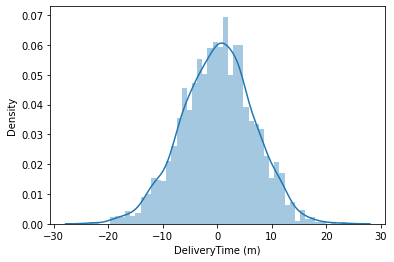

In [262]:
sns.distplot((ym_test-gbdt_predictions_m), bins=50)

In [263]:
DataFeats = ["Without day_of_week", "With day_of_week OneHot", "With day_of_week Angular"]
for i in range(len(X)):
    print(DataFeats[i])
    display(model_metrics_s[i])

Without day_of_week


,Model,MAE,MSE,RMSE,R2
0,Mean,619.032975,569247.206950,754.484729,-0.000018
1,Linear Regression,290.057970,123414.634860,351.304191,0.783193
2,Random Forest,302.742187,139704.695323,373.770913,0.754575
3,Gradient Boosted Decision Tree,314.644290,156384.984775,395.455414,0.725273


With day_of_week OneHot


,Model,MAE,MSE,RMSE,R2
0,Mean,619.032975,569247.206950,754.484729,-0.000018
1,Linear Regression,290.095703,123578.498894,351.537336,0.782905
2,Random Forest,298.785415,135759.237438,368.455204,0.761507
3,Gradient Boosted Decision Tree,312.209914,153962.743019,392.380865,0.729528


With day_of_week Angular


,Model,MAE,MSE,RMSE,R2
0,Mean,619.032975,569247.206950,754.484729,-0.000018
1,Linear Regression,290.094838,123487.250730,351.407528,0.783065
2,Random Forest,297.887352,134655.735744,366.954678,0.763445
3,Gradient Boosted Decision Tree,313.741738,154766.466474,393.403694,0.728116


In [264]:
for i in range(len(X)):
    print(DataFeats[i])
    display(model_metrics_m[i])

Without day_of_week


,Model,MAE,MSE,RMSE,R2
0,Mean,10.326068,158.240588,12.579372,-0.000022
1,Linear Regression,4.850609,34.505436,5.874133,0.781938
2,Random Forest,5.068789,38.944791,6.240576,0.753883
3,Gradient Boosted Decision Tree,5.313295,44.201209,6.648399,0.720665


With day_of_week OneHot


,Model,MAE,MSE,RMSE,R2
0,Mean,10.326068,158.240588,12.579372,-0.000022
1,Linear Regression,4.851274,34.552090,5.878103,0.781644
2,Random Forest,5.000909,37.993744,6.163907,0.759894
3,Gradient Boosted Decision Tree,5.247631,43.116409,6.566309,0.727520


With day_of_week Angular


,Model,MAE,MSE,RMSE,R2
0,Mean,10.326068,158.240588,12.579372,-0.000022
1,Linear Regression,4.851511,34.524513,5.875756,0.781818
2,Random Forest,5.007295,37.743791,6.143598,0.761473
3,Gradient Boosted Decision Tree,5.241641,43.514206,6.596530,0.725006


# Knowledge

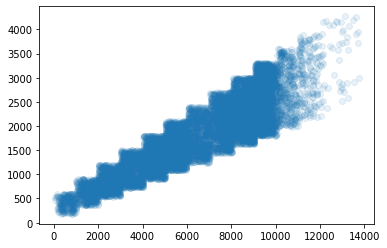

In [265]:
plt.scatter(df["EucDist"], y_s, alpha=0.1)

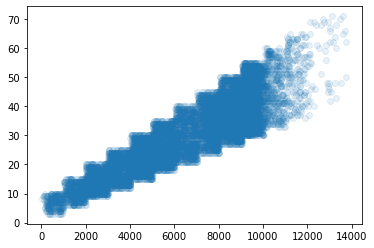

In [266]:
plt.scatter(df["EucDist"], y_m, alpha=0.1)

# Model Varirance

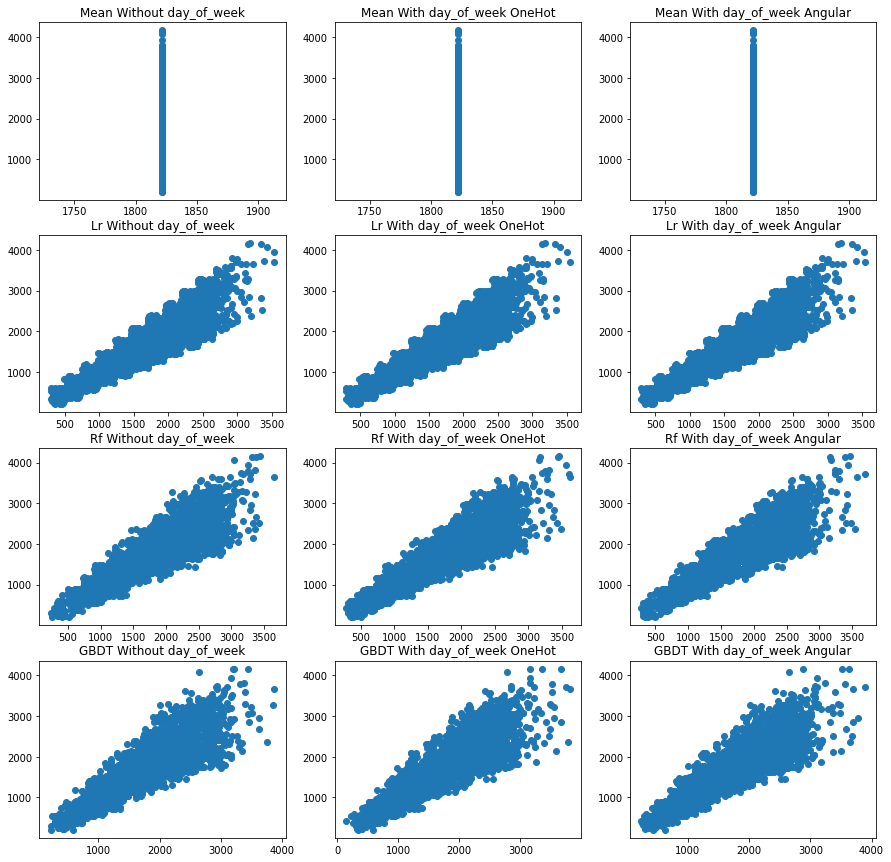

In [288]:
Names = ["Mean", "Lr", "Rf", "GBDT"]
#DataFeats
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
for i in range(len(X)):
    for j in range(len(Names)):
        axs[j, i].scatter(all_predictions_s[i][j], ys_tests[i])
        axs[j, i].set_title(Names[j]+" "+DataFeats[i])

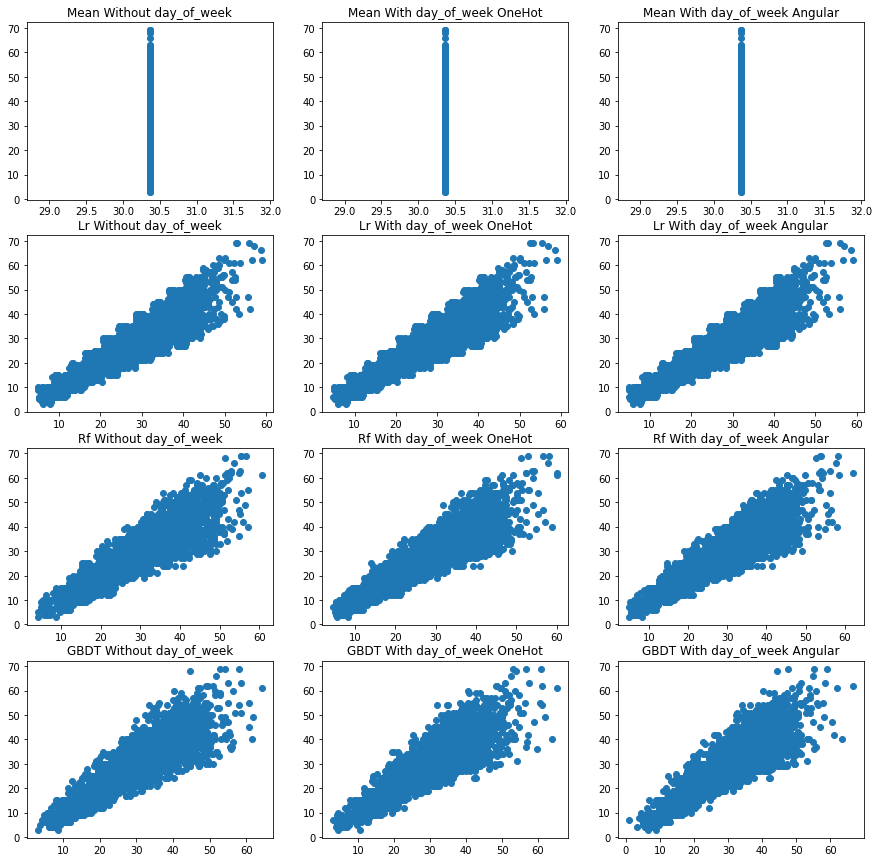

In [289]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
for i in range(len(X)):
    for j in range(len(Names)):
        axs[j, i].scatter(all_predictions_m[i][j], ym_tests[i])
        axs[j, i].set_title(Names[j]+" "+DataFeats[i])

# Error dist

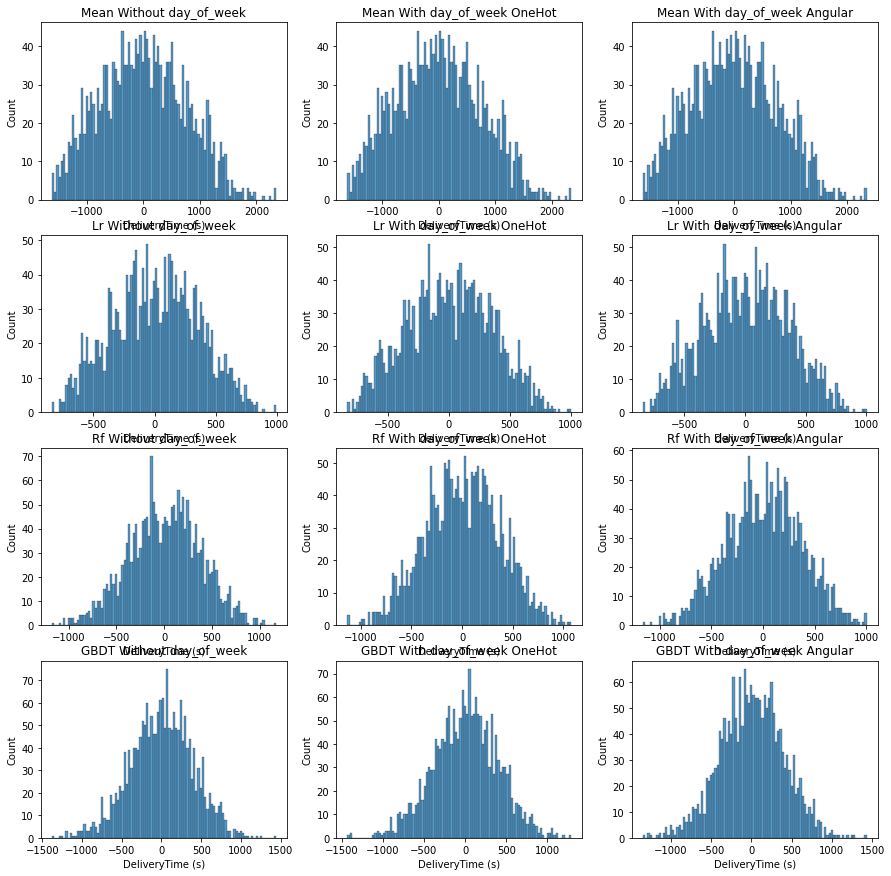

In [299]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
for i in range(len(X)):
    for j in range(len(Names)):
        sns.histplot((ys_test-all_predictions_s[i][j]), bins=100, ax=axs[j, i])
        axs[j, i].set_title(Names[j]+" "+DataFeats[i])

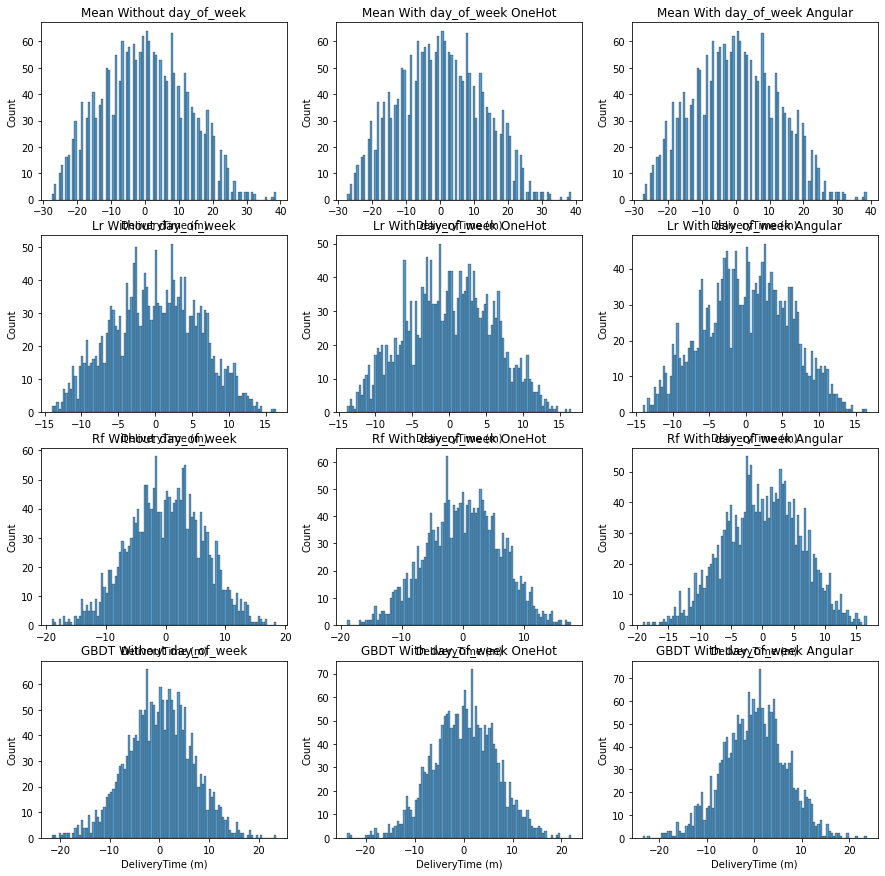

In [300]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
for i in range(len(X)):
    for j in range(len(Names)):
        sns.histplot((ym_test-all_predictions_m[i][j]), bins=100, ax=axs[j, i])
        axs[j, i].set_title(Names[j]+" "+DataFeats[i])